In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import math
from numba import jit
import pandas as pd
from scipy.integrate import solve_ivp

In [2]:
def drdt(t, r, m, rad):
    G = 6.6743e-11
    N = len(m)
    if len(r) != N:
        return 0
    elif len(rad) != N:
        return 0
    
    drdt = np.zeros((N,2,len(r[0,0])))
    dvdt = np.zeros((N,len(r[0,0])))
    for a in range(N):
        for b in range(N):
            if b!= a:
                if np.power(np.sum(np.power(r[a,0]-r[b,0],2)),1/2) < rad[a]:
                    dvdt[a] += -G*m[b]/(rad[a]**3)*(r[a,0]-r[b,0])*0
                dvdt[a] += -G*m[b]/np.power(np.sum(np.power(r[a,0]-r[b,0],2)),3/2)*(r[a,0]-r[b,0])
        drdt[a] = (r[a,1],dvdt[a])
    return drdt

In [3]:
def solve_nbody(f, planets, t_range, dt=0.1):
    r0 = np.stack(planets[0], axis=0)
    m = planets[1]
    rad = planets[2]
    
    t = np.arange(t_range[0], t_range[1] + dt, dt)  # Adjusted endpoint for t_range
    r = np.zeros((len(t), len(m), 2, len(r0[0][0])))
    r[0] = r0

    for i in range(len(t) - 1):
        k1 = dt * f(t[i], r[i], m, rad)
        k2 = dt * f(t[i] + dt / 2, r[i] + k1 / 2, m, rad)
        k3 = dt * f(t[i] + dt / 2, r[i] + k2 / 2, m, rad)
        k4 = dt * f(t[i] + dt, r[i] + k3, m, rad)

        r[i+1] = r[i] + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return t, r

In [4]:
def update(frame, t, r, planets, title = 'N-Body System', lim = 4.545e12, projection = '2d'):
    frame = int(round(frame,0))
    ax.clear()
    if projection == '3d':
        if len(r[0,0,0]) == 3:
            for i in range(len(planets.columns)):
                ax.plot(r[:frame+1,i,0,0],r[:frame+1,i,0,1],r[:frame+1,i,0,2],linewidth = 1, c='#4a4a4a')
                ax.plot(r[frame,i,0,0],r[frame,i,0,1],r[frame,i,0,2], '.', c = planets.loc['Color'][i], markersize = 10, label = planets.keys()[i])
            ax.plot(0,0,0,'.',c='white',markersize=5,label='Barycenter')
        elif len(r[0,0,0]) == 2:
            for i in range(len(planets.columns)):
                ax.plot(r[:frame+1,i,0,0],r[:frame+1,i,0,1],np.zeros_like(r[:frame+2,i,0,0]),linewidth = 1, c='#4a4a4a')
                ax.plot(r[frame,i,0,0],r[frame,i,0,1], '.',np.zeros_like(r[frame,i,0,0]),c = planets.loc['Color'][i], markersize = 10)
            ax.plot(0,0,0,'.',c='white',markersize=5,label='Barycenter')
        else:
            return 0
    elif projection == '2d':
        for i in range(len(planets.columns)):
            ax.plot(r[:frame+1,i,0,0],r[:frame+1,i,0,1],linewidth = 1,c = '#4a4a4a')
            ax.plot(r[frame,i,0,0],r[frame,i,0,1],'.',c = planets.loc['Color'][i],markersize = 10,label = planets.keys()[i])
        plt.plot(0,0,'.',c='white',markersize=5,label='Barycenter')
    else:
        return 0
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('black')
    if projection == '3d':
        ax.set_zticks([])
        ax.plot([0,0],[0,0],[-lim,lim],'.',markersize=0,linewidth=0)
    ax.set_xlim((-lim,lim)) 
    ax.set_ylim((-lim,lim))
    ax.set_title(title + ', {:.0f} yrs'.format(t[frame]*3.16887645e-8))
    plt.legend(fontsize = 6)

In [7]:
# ephemerides as of 2023-Dec-09 00:00
planets = pd.DataFrame({
    "Sun": [np.array(([-1.208468288340325E+09,-4.101221321268774E+08, 3.161378487769907E+07],[ 8.132438465968415E-03,-1.258524150077139E+01,-7.362920356072077E-02])),1988500e24, 695700e3, '#fdb813'],
    "Mercury": [np.array(([ 4.958218271913237E+10, 7.716944644534854E+09,-3.962963158883058E+09],[-1.710433370320160E+04, 5.026576488672420E+04, 5.678352128806715E+03])),3.302e23,2440e3, '#b7b8b9'],
    "Venus": [np.array(([-9.302243471837232E+10, 5.519395558080115E+10, 6.092986978499804E+09],[-1.827601853777037E+04,-3.014002101069308E+04, 6.411856514626564E+02])),48.685e23,6051.84e3, '#b53b03'],
    "Earth": [np.array(([ 3.369289240871894E+10, 1.427592426346152E+11, 2.347441957670450E+07],[-2.942424993521024E+04, 6.940529053586026E+03, 7.972164728866638E-01])),5.97219e24, 6371.01e3, '#668d3c'],
    "Mars": [np.array(([-9.268770141681714E+10,-2.070162459921039E+11,-2.054363813163131E+09],[ 2.307517530457451E+04,-7.745624449352806E+03,-7.279509230238244E+02])),6.4171e23, 3389.92e3, '#b6732f'],
    "Jupiter": [np.array(([ 5.398653838535976E+11, 5.116456785841523E+11,-1.420096141449165E+10],[-9.133258485225319E+03, 1.010283210504554E+04, 1.624350383931494E+02])),1.8981872e27, 69911e3, '#ddbca6'],
    "Saturn": [np.array(([ 1.338220253176969E+12,-5.740154831535478E+11,-4.330038554745293E+10],[ 3.267328453436888E+03, 8.859113843460729E+03,-2.843991197153892E+02])),5.6834e26, 58232e3, '#fde552'],
    "Uranus": [np.array(([ 1.845161481390729E+12, 2.280599026478859E+12,-1.543423951424718E+10],[-5.344441994946663E+03, 3.966101597272127E+03, 8.389054115362771E+01])),86.813e24,25362e3,'#ace5ee'],
    "Neptune": [np.array(([ 4.462664596643552E+12,-2.791948982226632E+11,-9.709691080761918E+10],[ 3.034783948725601E+02, 5.457110041281794E+03,-1.192063787699582E+02])),102.409e24, 24624e3, "#5b5ddf"]
})
planets.index = ['State', 'Mass', 'Radius', 'Color']
yr = 31557600 #seconds in a calendar year
day = 8.64e4 #seconds in a calendar day
t, r = solve_nbody(drdt, planets.to_numpy(), [0,100*yr],dt = day)

<IPython.core.display.Javascript object>


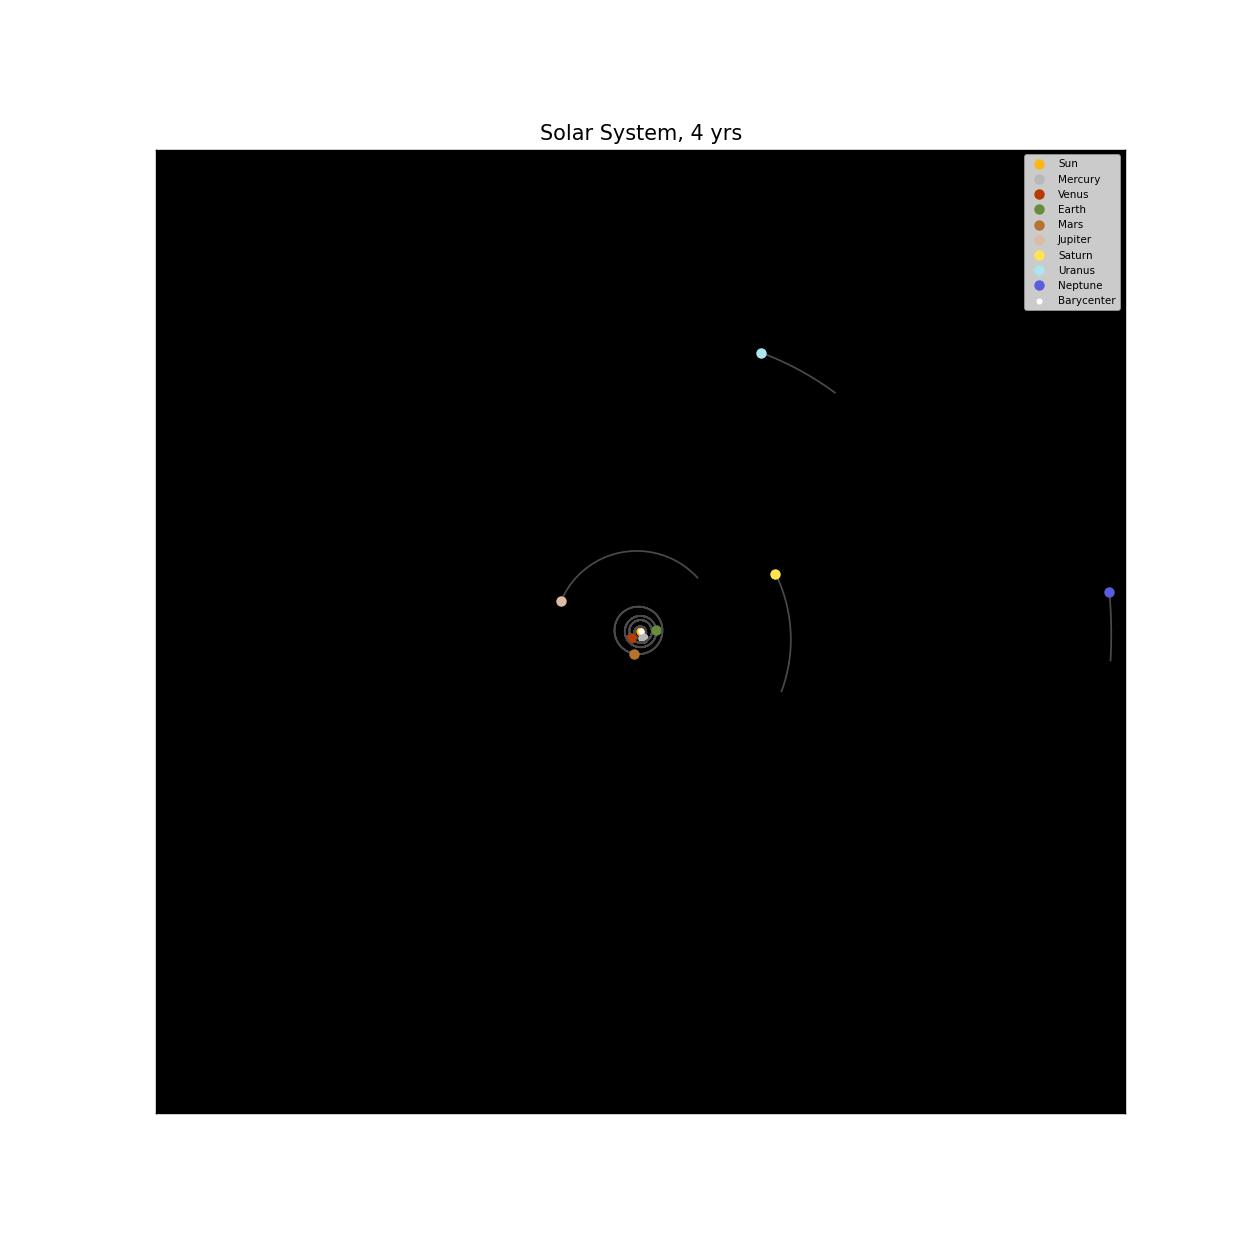

In [10]:
proj = '2d'
fig = plt.figure(figsize = (10,10))
if proj == '3d':
    ax = fig.add_subplot(projection = '3d')
elif proj == '2d':
    ax = fig.add_subplot()
ani = animation.FuncAnimation(fig, update, frames = np.arange(0,len(t),365.2422/5), fargs = [t, r, planets, 'Solar System',4.6e12])
writergif = animation.PillowWriter(fps = 24)
ani.save('sun.gif', writer = writergif)

<img src="sun.gif" width="750" align="center">